In [2]:
!pip install healpy
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import healpy as hp
import cv2
import math

In [ ]:
# Map pixels to RA and DEC values (theta and phi)
def register_pixels(img, fov, off):
    height, width = img.shape

    out = []

    for y in range(height):
        for x in range(width):
            theta = x * fov / width
            phi = y * fov / width

            out.append((theta + off[0], phi + off[1], img[y, x]))

    return out

# Determine all overlapping spherical pixels from a pixel's center angle
def find_overlapping_pixels(angle, fov, width, height):
    pixel_size_x = fov / width
    pixel_size_y = fov / height

    vecs = np.array([
        hp.ang2vec((angle[0] - pixel_size_x/2) % math.pi, (angle[1] - pixel_size_y/2) % 2*math.pi),
        hp.ang2vec((angle[0] + pixel_size_x/2) % math.pi, (angle[1] - pixel_size_y/2) % 2*math.pi),
        hp.ang2vec((angle[0] + pixel_size_x/2) % math.pi, (angle[1] + pixel_size_y/2) % 2*math.pi),
        hp.ang2vec((angle[0] - pixel_size_x/2) % math.pi, (angle[1] + pixel_size_y/2) % 2*math.pi),
    ])

    return hp.query_polygon(NSIDE, vecs)

# Perform bilinear interpolation on spherical pixels referencing the original image
def bilinear_interpolation(pix, img, fov, off):
    height, width = img.shape

    center = hp.pix2ang(NSIDE, pix)

    theta = center[0] - off[0]
    phi = center[1] - off[1]

    x = theta * width / fov
    y = phi * height / fov

    x_ceil = min(width - 1, math.ceil(x))
    x_floor = math.floor(x)
    y_ceil = min(width - 1, math.ceil(y))
    y_floor = math.floor(y)

    v1 = img[y_floor, x_floor]
    v2 = img[y_floor, x_ceil]
    v3 = img[y_ceil, x_ceil]
    v4 = img[y_ceil, x_floor]

    if x_ceil == x_floor and y_ceil == y_floor:
        return img[y_floor, x_floor]
    if x_ceil == x_floor:
        return v1 * (y_ceil - y) + v3 * (y - y_floor)
    if y_ceil == y_floor:
        return v1 * (x_ceil - x) + v2 * (x - x_floor)
    else:
        q1 = v1 * (x_ceil - x) + v2 * (x - x_floor)
        q2 = v3 * (x_ceil - x) + v4 * (x - x_floor)
        return q1 * (y_ceil - y) + q2 * (y - y_floor)

(326, 580)
{149797, 149798, 104208, 152396, 149799, 149800, 149801, 149802, 149803, 104213, 152397, 149804, 152917, 149805, 149806, 149807, 149808, 152398, 123757, 149809, 149810, 149811, 149812, 149813, 104223, 152399, 149814, 149815, 106811, 149816, 149817, 149818, 152400, 149819, 149820, 149821, 149822, 149823, 152401, 149824, 149825, 149826, 149827, 152402, 149828, 149829, 149830, 149831, 149832, 152403, 149833, 104243, 149834, 104244, 149835, 104245, 149836, 149837, 152404, 149838, 149839, 149840, 104250, 149841, 149842, 130304, 149843, 152405, 130305, 149844, 130306, 149845, 104255, 130307, 149846, 130308, 149847, 98560, 98561, 98562, 98563, 98564, 98565, 98566, 98567, 98568, 98569, 98570, 98571, 98572, 98573, 98574, 98575, 98576, 98577, 98578, 98579, 98580, 98581, 98582, 98583, 98584, 98585, 98586, 98587, 98588, 98589, 98590, 98591, 98592, 98593, 98594, 98595, 98596, 131356, 131357, 131358, 131359, 131360, 131361, 131362, 131363, 131364, 98597, 98598, 98599, 98600, 98601, 98602,

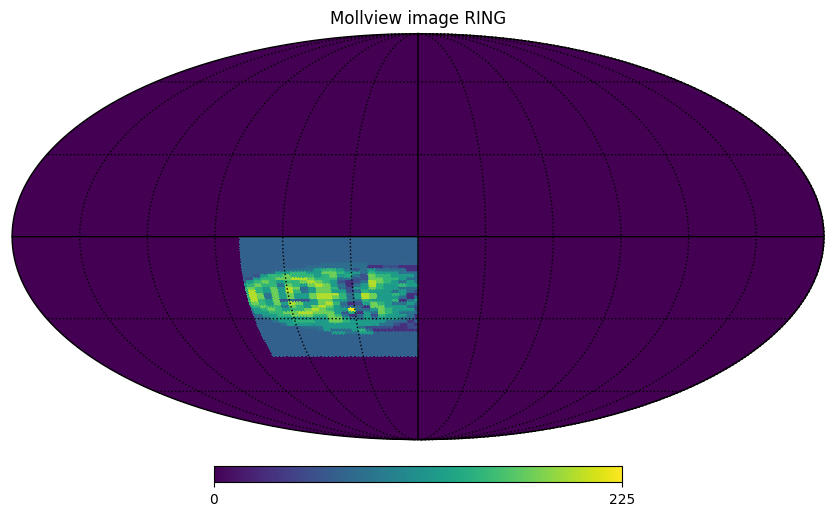

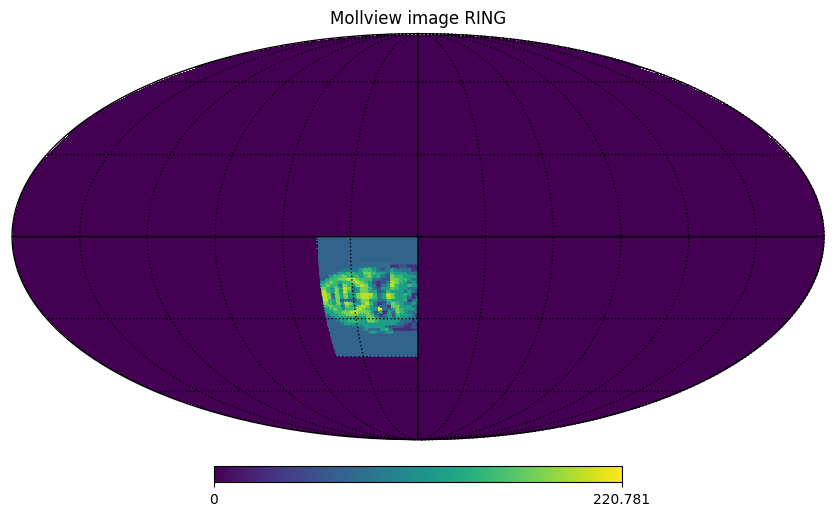

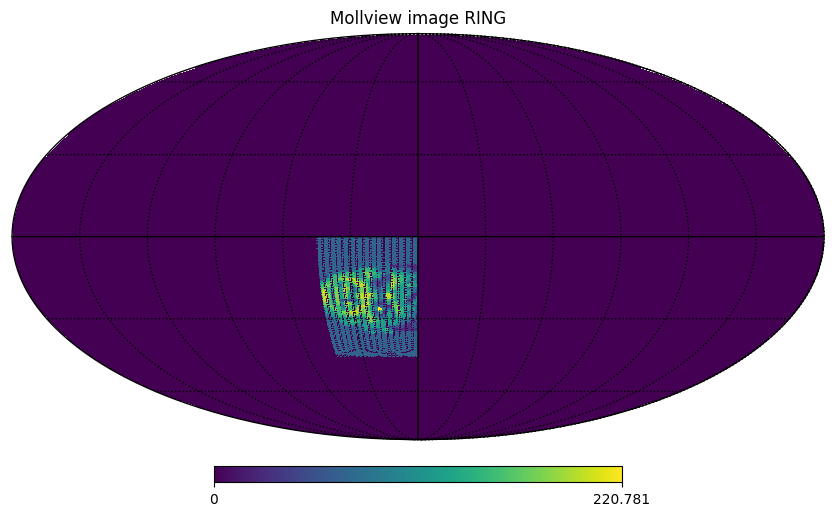

In [10]:
img = cv2.imread("guy.jpg")
# img = cv2.resize(img, (0,0), fx=0.1, fy=0.1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print(img.shape)

height, width = img.shape

NSIDE = 128
NPIX = hp.nside2npix(NSIDE)

FOV = math.pi/4
OFFSET = [math.pi/2, 0]

m = np.zeros(NPIX)

angles = register_pixels(img, FOV, OFFSET)

sp = set()
spi = set()

for angle in angles:
    res = find_overlapping_pixels(angle, FOV, width, height)
    m[res] = angle[2]
    spi.update(sp.intersection(res))
    sp.update(res)

print(sp)

hp.mollview(m, title="Mollview image RING", xsize=8000)
hp.graticule()

m2 = np.zeros(NPIX)

for p in sp:
    try:
        m2[p] = bilinear_interpolation(p, img, FOV, OFFSET)
        # print(m2[p])
    except Exception as e:
        print(e)
        continue

hp.mollview(m2, title="Mollview image RING")
hp.graticule()

m3 = np.zeros(NPIX)

for p in spi:
    try:
        m3[p] = bilinear_interpolation(p, img, FOV, OFFSET)
        # print(m2[p])
    except Exception as e:
        print(e)
        continue

hp.mollview(m3, title="Mollview image RING")
hp.graticule()
